In [1]:
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [4]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [5]:
# Define the file path
file_path = r"C:\Users\muski\Desktop\NewProject\Part II\Software.json"

In [6]:
# Create empty lists to store data
reviewerID_list = []
asin_list = []
reviewerName_list = []
vote_list = []
style_list = []
reviewText_list = []
overall_list = []
summary_list = []
unixReviewTime_list = []
reviewTime_list = []

In [7]:
# Read JSON data
with open(file_path, 'r') as file:
    for line in file:
        try:
            data = json.loads(line)

            # Append data to respective lists
            reviewerID_list.append(data.get('reviewerID'))
            asin_list.append(data.get('asin'))
            reviewerName_list.append(data.get('reviewerName'))
            vote_list.append(data.get('vote'))
            style_list.append(data.get('style'))
            reviewText_list.append(data.get('reviewText'))
            overall_list.append(data.get('overall'))
            summary_list.append(data.get('summary'))
            unixReviewTime_list.append(data.get('unixReviewTime'))
            reviewTime_list.append(data.get('reviewTime'))

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

In [8]:
# Create a DataFrame
df = pd.DataFrame({
    'reviewerID': reviewerID_list,
    'asin': asin_list,
    'reviewerName': reviewerName_list,
    'vote': vote_list,
    'style': style_list,
    'reviewText': reviewText_list,
    'overall': overall_list,
    'summary': summary_list,
    'unixReviewTime': unixReviewTime_list,
    'reviewTime': reviewTime_list
})

In [9]:
# Display the DataFrame
print(df.head())

       reviewerID        asin         reviewerName  vote  \
0  A240ORQ2LF9LUI  0077613252           Michelle W  None   
1  A1YCCU0YRLS0FE  0077613252  Rosalind White Ames  None   
2  A1BJHRQDYVAY2J  0077613252       Allan R. Baker     7   
3   APRDVZ6QBIQXT  0077613252                 Lucy     3   
4  A2JZTTBSLS1QXV  0077775473            Albert V.  None   

                        style  \
0  {'Format:': ' Loose Leaf'}   
1  {'Format:': ' Loose Leaf'}   
2  {'Format:': ' Loose Leaf'}   
3  {'Format:': ' Loose Leaf'}   
4                        None   

                                          reviewText  overall  \
0  The materials arrived early and were in excell...      4.0   
1  I am really enjoying this book with the worksh...      4.0   
2  IF YOU ARE TAKING THIS CLASS DON"T WASTE YOUR ...      1.0   
3  This book was missing pages!!! Important pages...      3.0   
4  I have used LearnSmart and can officially say ...      5.0   

                         summary  unixReviewTime 


## Analysis
### 1.  correlation between the product's rating and the review's helpfulness?

In [10]:
# Convert 'vote' column to numeric (removing non-numeric characters)
df['vote'] = pd.to_numeric(df['vote'].str.replace(r'\D', ''), errors='coerce')

In [11]:
# Calculate the correlation
correlation = df['overall'].corr(df['vote'])

In [12]:
# Print the correlation coefficient
print(f"Correlation between product's rating and review's helpfulness: {correlation}")

Correlation between product's rating and review's helpfulness: -0.017070877080897048



The correlation coefficient of -0.017 suggests a very weak negative correlation between the product's rating and the helpfulness of its reviews. The practical significance of this correlation is likely minimal, and other factors may influence the relationship between these variables.


### 2. Who are the most helpful reviewers?

In [13]:
# Group by reviewerID and sum the helpful votes
reviewer_votes = df.groupby('reviewerID')['vote'].sum()


In [14]:
# Sort the reviewers by the total helpful votes in descending order
most_helpful_reviewers = reviewer_votes.sort_values(ascending=False)


In [15]:
# Display the most helpful reviewers
print("Most Helpful Reviewers:")
print(most_helpful_reviewers.head())


Most Helpful Reviewers:
reviewerID
A1MRPX3RM48T2I    2375.0
A5JLAU2ARJ0BO     2063.0
A2D1LPEUCTNT8X    2033.0
A3MQAQT8C6D1I7    1846.0
A15S4XW3CRISZ5    1470.0
Name: vote, dtype: float64



### 3. Have reviews been getting more or less helpful over time?

In [16]:
# Convert 'unixReviewTime' column to datetime
df['reviewDate'] = pd.to_datetime(df['unixReviewTime'], unit='s')

In [17]:
# Group by review date and sum the helpful votes
helpful_votes_over_time = df.groupby('reviewDate')['vote'].sum()
helpful_votes_over_time

reviewDate
1998-12-04      0.0
1999-03-14      3.0
1999-06-18      0.0
1999-10-23      2.0
1999-11-10    127.0
              ...  
2018-09-23      0.0
2018-09-24      0.0
2018-09-26      0.0
2018-10-01      0.0
2018-10-02      0.0
Name: vote, Length: 6865, dtype: float64

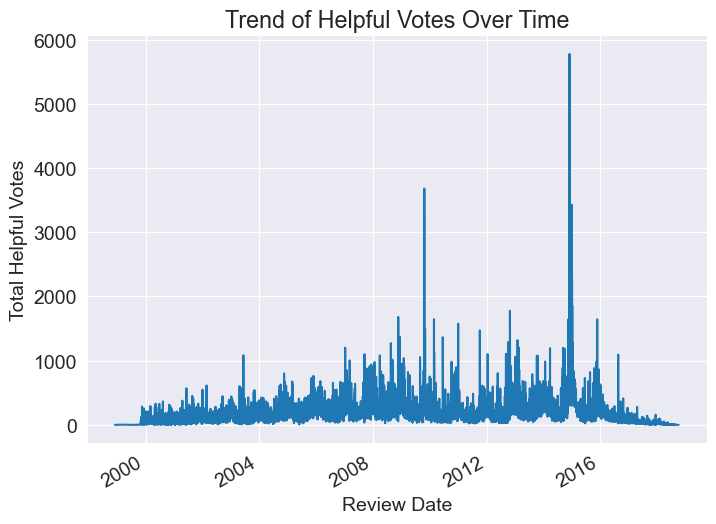

In [18]:
# Plot the trend
plt.figure(figsize=(8, 6))
helpful_votes_over_time.plot(title='Trend of Helpful Votes Over Time')
plt.xlabel('Review Date')
plt.ylabel('Total Helpful Votes')
plt.show()

# Modelling


In [19]:
# Convert 'vote' column to numeric
df['vote'] = pd.to_numeric(df['vote'], errors='coerce')

In [20]:
# Create a binary label for helpfulness (e.g., if 'vote' is above a certain threshold, label it as 1, else label it as 0)
df['helpful'] = (df['vote'] > 5).astype(int)

In [21]:
#check for null values
print(df['reviewText'].isnull().sum())

66


In [22]:
#replace nan with empty strings
df['reviewText'].fillna('', inplace=True)

#### Feature Engineering: Text vectorization using TF-IDF for 'reviewText'

In [23]:

tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_text = tfidf_vectorizer.fit_transform(df['reviewText'])

In [24]:
# Concatenate TF-IDF features with other relevant features
X_features = pd.concat([df[['overall']], pd.DataFrame(X_text.toarray())], axis=1)


In [25]:
print(df['helpful'].shape)

(459436,)


In [26]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, df['helpful'], test_size=0.2, random_state=42)

#### The XGBoost (Extreme Gradient Boosting) model was used. XGBClassifier for implementation of gradient boosting

In [ ]:
# Initialize and train the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
# Make predictions on the testing set
y_pred = model.predict(X_test)


In [ ]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

#### 1. The overall accuracy of the model is 88.96%, which indicates the proportion of correctly predicted instances among all instances. 
#### 2. A precision of 56% means that among the instances predicted as helpful, 56% were actually helpful
#### 3. Recall of 18% indicates that the model identified only 18% of the actual helpful instances.
#### 4. The harmonic mean F1-score is relatively low, indicating a trade-off between precision and recall.


The model performs well in identifying non-helpful instances (high precision and recall for class 0).
However, the performance is weaker for identifying helpful instances (low precision and recall for class 1).
The class imbalance is evident from the large number of non-helpful instances (class 0) compared to helpful instances (class 1).


1. Given the class imbalance, I will consider techniques like oversampling, undersampling, or adjusting class weights to improve the model's performance on the minority class.
2. Fine-tune hyperparameters, especially those related to handling imbalanced data and model complexity.
3. Consider incorporating additional features or experimenting with different models to capture more nuanced patterns in the data.